In [ ]:
# import necessary packages

import torch
from torch import nn
import os
import glob as glob
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import time
import torch.multiprocessing as mp
from IPython.display import clear_output, display

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu") # check to see if GPU is avialable and use if possible
print(device)

cuda:0


In [ ]:
# instantiate dataset class using preexisiting torch dataset
class Dataset(Dataset):
    def __init__(self, file_dir, transform=None, target_transform=None):
        self.file_dir = file_dir                            # read in path to file directory
        self.files = glob.glob(self.file_dir)               # read in all csv files in the directory
        
        self.solutions = []                                 # create solutions list
        for file in self.files:                             # loop through all files
            for s in file.split('/')[-2].split('_'):        # get solutions based off of file name
                if s != '' and s not in self.solutions:     # if solution is not already in the list add it
                    self.solutions.append(s)
        self.one_hot_labels = {}                            # create one-hot label dictionary
        for file in self.files:                             # loop through all files
            z = np.zeros(len(self.solutions))               # create a list of all zeros
            file_label = file.split('/')[-2].split('_')     # get solutions based off of file name
            for f in file_label:                            # loop through all solutions in the file
                if f != '':                                 # ensure a real solution
                    z[self.solutions.index(f)] = 1          # set index of solution in the list of zeros equal to 1
            self.one_hot_labels[file] = z                   # set the file name with the one-hot labeled list in the dictionary
    

    def __len__(self):                                      # create len function
        return len(self.files)                              # return len of the dataset
    
    def __getitem__(self, idx):                             # create get item function
        file = self.files[idx]      
        #print(file)
        # select a file from list of files based off of index
        data = pd.read_pickle(file)

        #data = pd.read_csv(file, index_col=0)               # read in data from the file
        label = self.one_hot_labels[file]                   # fetch file label from one-hot labels dictionary
        data = data.to_numpy()                              # convert data to numpy array
        
        return np.array([data]), label                      # return formatted data and corresponding label

In [56]:
path = '/*/*.pkl'

dataset = Dataset(path) # call the dataset class with correct path

In [57]:
dataset.__len__() # call dataset length

7905

In [58]:
dataset.solutions

['CFR', 'Saur', 'EFM', 'BTU', 'Bsub', 'CK', 'Psaer', 'Scap']

In [59]:
data, label = dataset.__getitem__(10) # get an item from the dataset

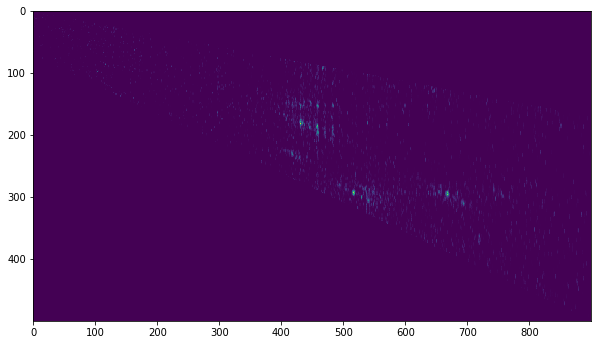

In [60]:
plt.figure(figsize=(10,8)) # set figure size
plt.imshow(data[0])        # plot 2DMS spectra as a picture/image

In [9]:
train_set, test_set = random_split(dataset, [int(dataset.__len__()*0.7), dataset.__len__() - int(dataset.__len__()*0.7)])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True) # create train data loader function (built in pytorch)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False) # create test data loader function

In [24]:
test_set.__len__()

2372

In [11]:
class NeuralNetwork(nn.Module):                                           # create convolutional neural network class
    def __init__(self):                                                   # initiate the class
        super(NeuralNetwork, self).__init__()                             # import exising items from torch class
        self.network = nn.Sequential(                                     # create a Sequential neural network
            nn.Conv2d(1, 32, kernel_size=10, padding=1),                  # add first convolution layer
            nn.ReLU(),                                                    # activate first layer
            nn.Conv2d(32, 64, kernel_size=10, stride=2, padding=1),       # second convolution layer
            nn.ReLU(),                                                    # activate second layer
            nn.MaxPool2d(2,2),                                            # peform pooling on convolutions
        
            nn.Conv2d(64, 128, kernel_size=10, stride=2, padding=1),      # third convolution layer
            nn.ReLU(),                                                    # activate third layer
            nn.Conv2d(128, 128, kernel_size=10, stride=2, padding=1),     # fourth convolution layer
            nn.ReLU(),                                                    # activate fourth layer
            nn.MaxPool2d(2,2),                                            # perform pooling on convolutions
        
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=1),      # fifth convolution layer
            nn.ReLU(),                                                    # activate fifth layer
            nn.Conv2d(256, 256, kernel_size=5, stride=2, padding=1),      # sixth convolution layer
            nn.ReLU(),                                                    # activate sixth layer
            nn.MaxPool2d(2,2),                                            # perform pooling on convolutions
        
            nn.Flatten(),                                                 # flatten convolutions into a 1xN array
            nn.Linear(512, 1024),                                         # feed into dense network
            nn.ReLU(),                                                    # activate neurons
            nn.Linear(1024, 512),                                         # feed into dense network
            nn.ReLU(),                                                    # activate neurons
            nn.Linear(512,8),                                            # feed into dense network
            nn.Sigmoid())                                                 # perform final activation (all between 0 and 1)
            
    def forward(self, x):            # create forward function
        return self.network(x)       # return network

In [11]:
model = NeuralNetwork()    # call convolutional neural network
model.to(device)           # send network to GPU
print(model)               # print model characteristics

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=512, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in

In [12]:
loss_fn = nn.BCELoss()                            # define loss function for model; using Binary Cross Entropy Loss
opt = optim.Adam(model.parameters(), lr=1e-3)     # define optimizer for model; using Adam optimizer with a 1e-3 learning rate

In [13]:
old_loss = 1000                                              # create arbitrary "old loss"
path = './CNN_MkI.pth'                    # create path to save model
for epoch in range(25):                                      # loop through desired number of epochs
    with tqdm(train_loader, unit='batch') as tepoch:         # setup data display                               
        correct=0                                            # instantiate counter for correct model predictions
        total=0                                              # instantiate counter for total model predictions
        for data, labels in tepoch:                          # get data (2DMS image) and one-hot encoded label
            tepoch.set_description(f'Epoch {epoch+1}')       # update data display description
            data, labels = data.to(device), labels.to(device)# send data and label to the GPU
            opt.zero_grad()                                  # zero out optimizer gradients
            outputs = model(data.float())                    # send data to model and get predicted values
            loss = loss_fn(outputs, labels.float())          # compute los between model predictions and actual values
            loss.backward()                                  # back-propagate the loss through the neural network
            opt.step()                                       # use optimizer to calculate gradients
            
            preds = []                                       # make an empty list for model predictions
            acts = []                                        # make an empty list for actual solutions
            for i in range(len(outputs[0])):                 # loop through all indices in the model output
                if outputs[0][i] >= 0.5:                     # if value is greater than or equal to 0.5 add to predictions list
                    preds.append(dataset.solutions[i])       # add value to predictions list
                if labels[0][i] == 1:                        # if actual label is present
                    acts.append(dataset.solutions[i])        # add label to actual list
            
            total+=len(acts)                                 # update total predictions made
            for p in preds:                                  # loop through list of predictions
                if p in acts:                                # if prediction is acutally corrcet
                    correct+=1                               # update correct counter

            tepoch.set_postfix(loss=round(loss.item(),8), accuracy=100*correct//total) # set data display description to show loss and accuracy or model
            
        if loss.item() <  old_loss:                          # if loss has decreased
            torch.save(model.state_dict(), path)             # save model to desired path
            old_loss = loss.item()                           # update loss variable

print('Finished Training')                                   # print when training loop is finished

Epoch 1:   0%|          | 0/346 [00:00<?, ?batch/s]/home/griffin/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 12:  38%|███▊      | 132/346 [02:12<03:34,  1.00s/batch, accuracy=100, loss=0]   


KeyboardInterrupt: 

Predicted Solutions: ['Saur']
Actual Solutions: ['Saur']


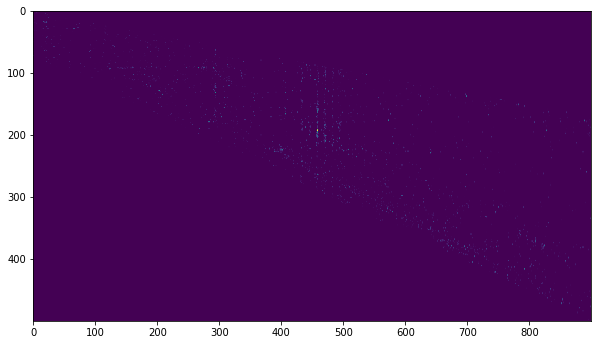

In [62]:
# eval one at a time
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
dataiter = iter(test_loader)
data, labels = dataiter.next()

plt.figure(figsize=(10,8))
plt.imshow(data[0][0])
#print(labels[0])

model = NeuralNetwork()
model.load_state_dict(torch.load(path))
model.eval()

with torch.no_grad():
    outputs = model(data.float())
    #print(outputs)
    preds = []
    acts = []
    for i in range(len(outputs[0])):
        if outputs[0][i] >= 0.5:
            preds.append(dataset.solutions[i])
        if labels[0][i] == 1:
            acts.append(dataset.solutions[i])

    print(f'Predicted Solutions: {preds}')
    print(f'Actual Solutions: {acts}')

In [22]:
# eval entire dataset
test_set = dataset
path = './CNN_MkI.pth' 
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
dataiter = iter(test_loader)
model = NeuralNetwork()
model.load_state_dict(torch.load(path))
model.eval()
tc = 0
t = 0
with torch.no_grad():
    for j in range(len(dataiter)):
        data, labels = dataiter.next()
        outputs = model(data.float())
        
        preds = []
        acts = []
        for i in range(len(outputs[0])):
            if outputs[0][i] >= 0.5:
                preds.append(dataset.solutions[i])
            if labels[0][i] == 1:
                acts.append(dataset.solutions[i]) 

        t += len(acts)
        if acts == preds:
            tc += len(acts)
print(f'Prediction Accuracy: {tc*100//t} %')

Prediction Accuracy: 88 %


In [23]:
# create confusion matrix
test_set = dataset
path = './CNN_MkI.pth' 
solution_data = {}
for file in dataset.files:
    s = file.split('/')[-2]
    if s not in solution_data:
        solution_data[s] = np.zeros(len(dataset.solutions))

test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
dataiter = iter(test_loader)
model = NeuralNetwork()
model.load_state_dict(torch.load(path))
model.eval()

with torch.no_grad():
    for j in range(len(dataiter)):
        data, labels = dataiter.next()
        outputs = model(data.float())
        
        pred_idx = []
        acts = ''
        
        for i in range(len(outputs[0])):
            if outputs[0][i] >= 0.5:
                pred_idx.append(i)
        for i in range(len(labels[0])):
            if labels[0][i] == 1:
                acts+=dataset.solutions[i]+'_'

        for idx in pred_idx:
            solution_data[acts][idx] += 1
        #print(solution_data)
        #break

In [24]:
solution_data

{'CFR_': array([17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'Saur_': array([ 0., 15.,  0.,  0.,  0.,  0.,  0.,  1.]),
 'EFM_': array([ 0.,  0., 21.,  0.,  0.,  0.,  0.,  0.]),
 'BTU_': array([ 0.,  0.,  1., 18.,  0.,  0.,  0.,  0.]),
 'Bsub_': array([ 1.,  0.,  0.,  0., 17.,  0.,  0.,  0.]),
 'CK_': array([ 0.,  0.,  0.,  0.,  0., 17.,  0.,  0.]),
 'Psaer_': array([ 1.,  0.,  1.,  2.,  0., 10.,  2.,  0.]),
 'Scap_': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 18.])}

In [ ]:
# find important pixels
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
dataiter = iter(test_loader)

solution_features = {}

for j in range(len(dataiter)):
    data, labels = dataiter.next()
    acts = ''
    for i in range(len(labels[0])):
        if labels[0][i] == 1:
            acts+=dataset.solutions[i]+'_'
    if acts in solution_features:
        pass
    else:
        solution_features[acts] = []
        for f in range(500):
            for n in range(900):
                if data[0][0][f][n] > 0.1:
                    solution_features[acts].append([f,n])

In [ ]:
for sol in solution_features.keys():
    d= np.zeros([500,900])
    for i in range(len(solution_features[sol])):
        x = solution_features[sol][i][0]
        y = solution_features[sol][i][1]
        d[x][y] = 1

    print(sol)
    plt.imshow(d)
    plt.show()

Predicted Solutions: ['S. capitis']
Actual Solutions: ['S. capitis']


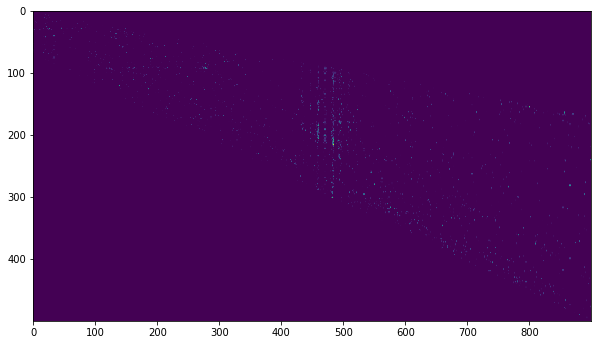

In [77]:
%matplotlib inline
# eval one at a time
test_set = dataset
path = './CNN_MkI.pth' 
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
for i in range(25):
    clear_output(wait=True)
    dataiter = iter(test_loader)
    data, labels = dataiter.next()

#     plt.figure(figsize=(10,8))
#     plt.imshow(data[0][0])
#     plt.show()
    #print(labels[0])

    model = NeuralNetwork()
    model.load_state_dict(torch.load(path))
    model.eval()

    with torch.no_grad():
        outputs = model(data.float())
        #print(outputs)
        preds = []
        acts = []
        for i in range(len(outputs[0])):
            if outputs[0][i] >= 0.5:
                preds.append(sol_names[i])
            if labels[0][i] == 1:
                acts.append(sol_names[i])

        print(f'Predicted Solutions: {preds}')
        print(f'Actual Solutions: {acts}')
        plt.figure(figsize=(10,8))
        plt.imshow(data[0][0])
        plt.show()
    time.sleep(1.5)